In [134]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [135]:
X = np.load('x_letters.npy')
Y = np.load('y_letters.npy')

X_train_full, X_test, y_train_full, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [136]:
def build_discriminator(img_dim=28):
    # Input layers
    image_input = layers.Input(shape=(img_dim, img_dim))
    label_input = layers.Input(shape=(1,))

    # Flattening the image so that it can go into Dense 1D layers
    flat_image = layers.Flatten()(image_input)

    # Concatenate flattened image with label input
    concat = layers.Concatenate()([flat_image, label_input])

    # Feedforward network
    x = layers.Dense(50, activation="relu", kernel_initializer="he_normal")(concat)
    x = layers.Dense(15, activation="relu", kernel_initializer="he_normal")(x)

    # Output layer
    real_or_fake = layers.Dense(1, activation='sigmoid')(x)

    # Building the model
    return tf.keras.Model([image_input, label_input], real_or_fake)


def build_generator(img_dim=28, latent_dim=32):
    latent_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,))
    
    concat = layers.Concatenate()([latent_input, label_input])

    x = layers.Dense(100, activation="relu", kernel_initializer="he_normal")(concat)
    x = layers.Dense(150, activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Dense(250, activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Dense(28*28, activation="sigmoid")(x)

    generated_image = layers.Reshape((img_dim, img_dim))(x)
    
    return tf.keras.Model([latent_input, label_input], generated_image)



In [137]:
#Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data):
        real_images, real_labels = data
        batch_size = ops.shape(real_images)[0]

        # Creating random points and labels
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim),
            seed = self.seed_generator
        )
        random_labels = tf.random.uniform(
            shape=(batch_size,), minval=0, maxval=26, dtype=tf.int64
        )

        #Combine real and fake - images and labels
        generated_images = self.generator([random_latent_vectors, random_labels])

        combined_images = ops.concatenate([real_images, generated_images], axis=0)
        combined_labels = ops.concatenate([real_labels, random_labels], axis=0)
        # Assemble labels discriminating real from fake images
        real_or_fake_labels = ops.concatenate(
            [ops.ones((batch_size, 1))
            , ops.zeros((batch_size, 1))], 
            axis=0
        )

        # Add random noise to the labels - important trick!
        #basically makes sure the discriminator is not perfect,
        #so that the generator never has a chance to learn
        real_or_fake_labels += 0.2 * tf.random.uniform(tf.shape(real_or_fake_labels))

        # ---Train the discriminator---
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(real_or_fake_labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Creating random points and labels
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim),
            seed = self.seed_generator
        )
        random_labels = tf.random.uniform(
            shape=(batch_size,), minval=0, maxval=26, dtype=tf.int64
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.ones((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            generated_images = self.generator([random_latent_vectors, random_labels])
            predictions = self.discriminator([generated_images, random_labels])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [138]:
dis = build_discriminator()
gen = build_generator()

In [156]:
epochs = 50

gan = GAN(discriminator=dis, generator=gen, latent_dim=32)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.00009, clipvalue=1.0),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.002),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(X_train,y_train, epochs=epochs)

Epoch 1/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - d_loss: -0.4075 - g_loss: 4.0100
Epoch 2/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - d_loss: -4.5682 - g_loss: 5.8647
Epoch 3/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - d_loss: 0.9902 - g_loss: 2.1346
Epoch 4/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - d_loss: -5.0004 - g_loss: 3.6064
Epoch 5/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - d_loss: 5.3890 - g_loss: 1.3653
Epoch 6/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - d_loss: 8.9724 - g_loss: 2.6215
Epoch 7/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - d_loss: 1.0805 - g_loss: 2.3806
Epoch 8/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - d_loss: 4.9107 - g_loss: 1.2206
Epoch 9/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - d_loss: 12.0582 - g_loss: 0.7375
Epoch 10/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - d_loss: 13.5087 - g_loss: 1.1265
Epoch 11/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - d_loss: -5.7039 - g_loss: 4.3101
Epoch 12/50
2064/2064 ━━

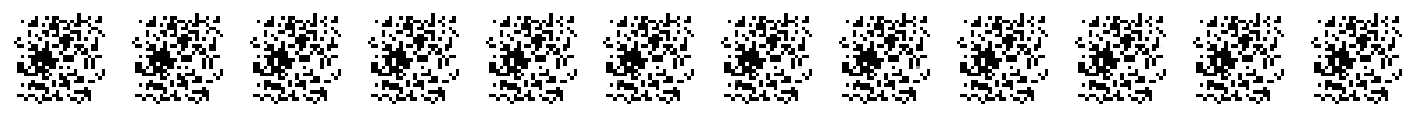

In [158]:
def plot_images(n_images, generator, latent_dim):
    random_latent_vectors = keras.random.normal(
            shape=(n_images, latent_dim), seed = keras.random.SeedGenerator(21)
        )
    random_labels = tf.random.uniform(
            shape=(n_images,), minval=0, maxval=26, dtype=tf.int64
        )
    
    images = generator([random_latent_vectors, random_labels])

    fig = plt.figure(figsize=(n_images * 1.5, 4.5))
    for image_index in range(n_images):
        plt.subplot(1, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
    plt.show()

plot_images(12, gan.generator, 32)